In [3]:
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.data import Dataset
from matplotlib import pyplot
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

2021-10-22 14:54:38.165913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 14:54:38.166262: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
df_23043 = pd.read_csv("../data/datasets_by_whale/1999CA-Bmu-23043.csv")[["location-long", "location-lat"]]

In [5]:
def split_data(df):

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):]
    #test_df = df[int(n*0.9):]

    num_features = df.shape[1]
    
    return train_df, val_df#,test_df

In [6]:
train_df,val_df = split_data(df_23043)

In [7]:
def data_windowing(train_df,val_df):
    n_points = 20
    window_length = n_points+ 1 
    
    window_train = tf.keras.utils.timeseries_dataset_from_array(
    train_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    """
    window_test = tf.keras.utils.timeseries_dataset_from_array(
    test_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    """
        
    window_val = tf.keras.utils.timeseries_dataset_from_array(
    val_df, targets=None,sequence_length = window_length, sequence_stride=1, sampling_rate=1,
    batch_size=32, shuffle=False, seed=None, start_index=None, end_index=None)
    
    return window_train, window_val

In [8]:
def data_map(elem):
    n_points = 20
    window_length = n_points+ 1 
    X,y = elem[:,:-1,:],elem[:,-1:,0:2]
    X.set_shape([None, n_points, None])
    y.set_shape([None, window_length - n_points, None])
    
    return (X,y)


In [9]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=2)
])

2021-10-22 14:54:40.799768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-22 14:54:40.801068: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-22 14:54:40.801171: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-R3AGIN3): /proc/driver/nvidia/version does not exist
2021-10-22 14:54:40.803644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
lstm_model.compile(loss=tf.losses.MeanSquaredError(),optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=[tf.metrics.MeanAbsoluteError()])

In [11]:
window_train,window_val = data_windowing(train_df,val_df)
train = window_train.map(data_map)
#test = window_test.map(data_map)
val = window_val.map(data_map)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5,
                                                mode='min')

tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=2)

history = lstm_model.fit(train, epochs=100,
                         validation_data=val,
                         callbacks=[early_stopping, tensorboard_callback])




2021-10-22 14:54:40.975711: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-22 14:54:40.975753: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-22 14:54:40.978021: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-22 14:54:41.029185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
3/9 [=========>....................] - ETA: 0s - loss: 7692.4956 - mean_absolute_error: 76.6411

2021-10-22 14:54:42.709851: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-22 14:54:42.709899: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-22 14:54:42.729301: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-22 14:54:42.745254: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-22 14:54:42.786087: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_22_14_54_42

2021-10-22 14:54:42.801992: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_10_22_14_54_42/DESKTOP-R3AGIN3.trace.json.gz
2021-10-22 14:54:42.822218: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_10_22_14_54_42

2021-10-22 14:54:42.

9/9 [==============================] - 2s 79ms/step - loss: 7855.8887 - mean_absolute_error: 77.6339 - val_loss: 7310.7100 - val_mean_absolute_error: 73.0064
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 7847.0093 - mean_absolute_error: 77.5916 - val_loss: 7294.0513 - val_mean_absolute_error: 72.9053
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 7827.9082 - mean_absolute_error: 77.4823 - val_loss: 7277.1431 - val_mean_absolute_error: 72.8026
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 7806.0669 - mean_absolute_error: 77.3502 - val_loss: 7260.0220 - val_mean_absolute_error: 72.6988
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 7795.2715 - mean_absolute_error: 77.2934 - val_loss: 7242.3760 - val_mean_absolute_error: 72.5922
Epoch 6/100
9/9 [==============================] - 0s 17ms/step - loss: 7778.7632 - mean_absolute_error: 77.1960 - val_loss: 7221.8472 - val_mean_absolute_error: 

9/9 [==============================] - 0s 16ms/step - loss: 3093.4468 - mean_absolute_error: 44.6540 - val_loss: 2717.4014 - val_mean_absolute_error: 39.6579
Epoch 50/100
9/9 [==============================] - 0s 15ms/step - loss: 2902.8982 - mean_absolute_error: 42.7222 - val_loss: 2530.1968 - val_mean_absolute_error: 38.1475
Epoch 51/100
9/9 [==============================] - 0s 15ms/step - loss: 2673.2925 - mean_absolute_error: 40.5398 - val_loss: 2349.7236 - val_mean_absolute_error: 36.6574
Epoch 52/100
9/9 [==============================] - 0s 17ms/step - loss: 2485.8745 - mean_absolute_error: 38.6675 - val_loss: 2175.9700 - val_mean_absolute_error: 35.2631
Epoch 53/100
9/9 [==============================] - 0s 16ms/step - loss: 2371.7126 - mean_absolute_error: 37.2878 - val_loss: 2015.2936 - val_mean_absolute_error: 33.9892
Epoch 54/100
9/9 [==============================] - 0s 18ms/step - loss: 2128.5051 - mean_absolute_error: 34.6963 - val_loss: 1868.1923 - val_mean_absolute_er

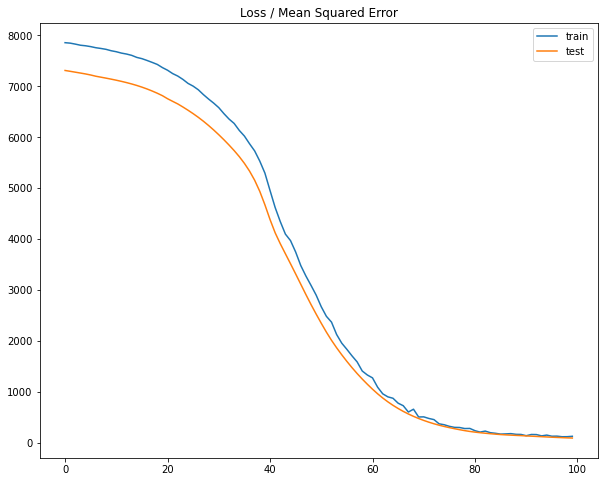

In [12]:
pyplot.figure(figsize=(10,8))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
list(val.take(1).as_numpy_iterator())[0][1][0][0]

array([-122.878,   37.589])

In [14]:
np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]).shape

(1, 20, 2)

In [15]:
lstm_model.layers[0].input_shape

(None, 20, 2)

In [16]:
np.array([val_df[:20]])

array([[[-123.14 ,   37.667],
        [-122.513,   37.741],
        [-123.055,   37.716],
        [-123.105,   37.725],
        [-123.265,   37.712],
        [-123.22 ,   37.522],
        [-123.032,   37.607],
        [-123.182,   37.659],
        [-122.89 ,   37.546],
        [-122.928,   37.625],
        [-122.907,   37.781],
        [-123.129,   37.588],
        [-122.951,   37.591],
        [-123.081,   37.509],
        [-123.017,   37.495],
        [-123.08 ,   37.577],
        [-122.968,   37.511],
        [-123.381,   37.576],
        [-122.904,   37.427],
        [-123.132,   37.471]]])

In [83]:
truth = val_df[:21]

In [18]:
y_pred = lstm_model.predict(np.array([val_df[:20]]))[0]

In [19]:
y_pred 

array([-117.59136 ,   40.478867], dtype=float32)

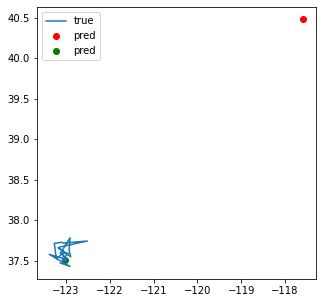

In [20]:
pyplot.figure(figsize=(5,5))
pyplot.plot(val_df[:20]["location-long"], val_df[:20]["location-lat"], label='true')
pyplot.scatter(y_pred[0], y_pred[1],  c="red", label='pred')
pyplot.scatter(val_df.iloc[21][0], val_df.iloc[21][1],  c="green", label='pred')
pyplot.legend()
pyplot.show()

In [21]:
val_df.iloc[21]

location-long   -123.031
location-lat      37.511
Name: 311, dtype: float64

In [74]:
import folium
from folium import Map, Marker

In [87]:
truth

,location-long,location-lat
290,-123.140,37.667
291,-122.513,37.741
292,-123.055,37.716
293,-123.105,37.725
294,-123.265,37.712
295,-123.220,37.522
296,-123.032,37.607
297,-123.182,37.659
298,-122.890,37.546
299,-122.928,37.625


In [90]:
truth = truth.to_numpy()

In [79]:
from folium import Map, Marker

In [93]:
 m = Map([28.773552, -115.176131])

for point in truth:
    folium.Marker(location=[point[1], point[0]]).add_to(m)

In [94]:
m

In [25]:
lstm_model.predict(np.array([list(val.take(1).as_numpy_iterator())[0][0][0]]))

array([[-117.97619 ,   33.007256]], dtype=float32)